# Installing Db2 on OpenShift

This lab will take the user through the steps required to get Db2 running on a Kubernetes cluster. In order to simulate a cluster, a combination of VirtualBox and Minikube are used to allow a single image system to behave as a cluser.

**Note**: Click on the next cell and press **Shift-Return** to refresh all of the examples in this notebook.

In [1]:
%run refresh.ipynb

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### How to Copy Code and Examples
Throughout this lab there are code samples that need to be copied and modified in a text editor. Any commands that need to be executed from a command line are found in grey boxes (an example is found below) has been designed to be easily copied.

In [2]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=111 onmousedown="window.clipline(111)" onmouseup="window.reset(111)">
Sample commands are found in cells like this.
</pre>
</div>

The entire contents of the text in the cell will be automatically copied when you click on the cell. The color of the background will change color briefly to indicate that the copy has completed. To paste commands into a terminal window, use the key combination **Control-Shift-v**. 

It may be easier to keep a terminal window on top of the Jupyter notebook when running these commands. When you have a terminal window displayed, right click on the title bar and select `Always on Top` to keep the screen visible during the duration of the lab.
<p>
<div style="border-style: solid; border-color: red; border-width: 3px; padding: 10px;" >
    <b>Note:</b> Open a terminal window to issue all of the <b>minikube</b> and <b>kubectl</b> commands. They will not work within this Jupyter notebook!
</div>

## Shutdown Minishift
This step is only required if you are running this lab a subsequent time. The entire Minishift environment needs to be reset in order to avoid any errors with the network.

```
minishift stop
minishift delete --force --clear-cache
rm -rf ~/.minishift
```

### Start MiniShift
Minikube is a single node Kubernetes cluster. The Start command when run for the first time will create a single node cluster applying configuration parameters passed to it such as CPU memory amongst other parameters.

In [2]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=1 onmousedown="window.clipline(1)" onmouseup="window.reset(1)">
minishift start --cpus=4 --memory='12g' --vm-driver=kvm
</pre>
</div>

Enable the MiniShift extensions.

```
minishift addons install --defaults
minishift addons enable admin-user
```

### Initialize Helm
Helm does package management for your Kubernetes cluster. When initialising an environment for Helm it sets ups a Tiller service on your Kubernertes cluster and prepares the environment for accepting application packages. Tiller is its enabling service on Kubernetes.

In [3]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=2 onmousedown="window.clipline(2)" onmouseup="window.reset(2)">
helm init --client-only
</pre>
</div>

Tiller setup in OpenShift
```
oc login -u system:admin -n default
oc delete project tiller
oc new-project tiller
export TILLER_NAMESPACE=tiller
```

Start a Tiller installation in the project
```
oc process -f https://github.com/openshift/origin/raw/master/examples/helm/tiller-template.yaml -p TILLER_NAMESPACE="${TILLER_NAMESPACE}" -p HELM_VERSION=v2.16.1 | oc create -f -
oc rollout status deployment tiller
```

Create a Db2 project and give Tiller access as well the security required for Db2.
```
oc new-project db2
oc policy add-role-to-user admin "system:serviceaccount:${TILLER_NAMESPACE}:tiller"
```

Add the Db2 profile and security contexts
```
cd ~/notebooks/extras/deployment
oc apply -f ./adm
```

Add the Db2 administrative profile to the project.
```
# If necessary # oc delete scc db2u-scc
oc adm policy add-scc-to-user db2u-scc system:serviceaccount:db2:db2u
```

Add the Db2 claim required to store the files.
```
cd ~/notebooks/extras
oc apply -f db2pvc.yaml
```

Update the virtual machine environment to allow access to the pv for any container/pods as well as allow the change in cgroup by a container. Usually you would use NFS and avoid all of this, but since we are running in a single image we override the security this way.
```
minishift ssh
sudo setsebool -P container_manage_cgroup 1
cd /var/lib/minishift/base/openshift.local.pv
sudo chmod -R 777 pv*
exit
```

Start the installation
```
cd ~/notebooks/extras/deployment
./db2u-install --db-type db2oltp --namespace db2 --release-name db2u --existing-pvc db2claim --tiller-namespace tiller --cpu-size 2 --memory-size 3Gi
```

Watch the installation.
```
oc get pods -w
```

Get the IP address of the cluster
```
minishift ip
```

Find the services that are available.
```
oc get svc
```

### Unpack the Db2 Installation Files
These files are required to set up security profiles for the cartridge that is being installed.

In [5]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=3 onmousedown="window.clipline(3)" onmouseup="window.reset(3)">
cd ~/notebooks/extras
unzip db2kube.zip
</pre>
</div>

### Create a Persistent Volume for Db2 to Use
Inherently, Kubernetes supports stateless applications, however with a database like Db2 we want any data written to persist past the life of a container. To do so we create a Persistent volume for our database to reside in so that whether containers are refreshed due to failover, resizing or upgrading the database itself persists.

In [6]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=4 onmousedown="window.clipline(4)" onmouseup="window.reset(4)">
kubectl apply -f db2pvc.yaml
</pre>
</div>

The `kubectl get pvc` command will give us a list of all persistent volumnes that have been created. The Db2 volume should be there.

In [7]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=4.1 onmousedown="window.clipline(4.1)" onmouseup="window.reset(4.1)">
kubectl get pvc
</pre>
</div>

### Setup the Cluster Administration
Setup the cluster security and admin pre-reqs  n the cluster to deploy the Db2 installation.

In [8]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=5 onmousedown="window.clipline(5)" onmouseup="window.reset(5)">
cd ~/notebooks/extras/clusterAdministration
./createSecurityClusterPrereqs.sh
</pre>
</div>

### Setup the Namespace Security
Apply the required security pre requisites for Db2 on the default Namespace so that Db2 can install.

In [9]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=6 onmousedown="window.clipline(6)" onmouseup="window.reset(6)">
cd ~/notebooks/extras/namespaceAdministration
./createSecurityNamespacePrereqs.sh default
</pre>
</div>

### Apply Db2 Roles
Apply the required Db2 roles to the cluster in preparation for the installation.

In [10]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=7 onmousedown="window.clipline(7)" onmouseup="window.reset(7)">
cd ~/notebooks/extras/deployment/adm
kubectl apply -f db2u-sa.yaml
kubectl apply -f db2u-role.yaml
kubectl apply -f db2u-rolebinding.yaml
</pre>
</div>

### Start the Db2 Installation
The script will ask you to review the legal disclaimer and license agreement. You can answer **q** to avoid reading the text and then type **y** to accept the license agreement. After you complete this step the installation will begin.

In [11]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=8 onmousedown="window.clipline(8)" onmouseup="window.reset(8)">
cd ~/notebooks/extras/deployment
./db2u-install --db-type db2oltp \
               --namespace default \
               --release-name db2u \
               --existing-pvc db2claim \
               --cpu-size 2 \
               --memory-size 3Gi
</pre>
</div>

### Check the Pod Status
Using Kubectl we can track the progress of the Db2 installation with the command below. "Jobs" will show complete once they have successfully performed their operation while services will show they are running when completed.

In [12]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=9 onmousedown="window.clipline(9)" onmouseup="window.reset(9)">
kubectl get pods
</pre>
</div>

You have the option of telling the `get pods` command to refresh the information on the screen without have to issue the command repeatedly.

In [13]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=9.1 onmousedown="window.clipline(9.1)" onmouseup="window.reset(9.1)">
kubectl get pods -w
</pre>
</div>

Note that the Db2 pod will not allow connections until the **READY** column shows **1/1**.
```
NAME                                READY   STATUS      RESTARTS   AGE
db2u-db2u-0                         1/1     Running     0          32m
db2u-db2u-ldap-5848d9c7f7-qnkmq     1/1     Running     0          32m
db2u-db2u-nodes-cfg-job-flvgj       0/1     Completed   0          32m
db2u-db2u-restore-morph-job-ppt4h   0/1     Completed   0          32m
db2u-db2u-sqllib-shared-job-k75hm   0/1     Completed   0          32m
db2u-db2u-tools-7b6644946d-cvgbq    1/1     Running     0          32m
db2u-etcd-0                         1/1     Running     0          32m
```

### Describe the Pods to see Status
By running the Describe command we can view a log of current state and historical events for the pod. Run the command and browse through the output.

In [14]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=9.2 onmousedown="window.clipline(9.2)" onmouseup="window.reset(9.2)">
kubectl describe pod db2u-db2u-0 
</pre>
</div>

### Get the Service Accounts
List the service accounts that services run under on your cluster.

In [15]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=10 onmousedown="window.clipline(10)" onmouseup="window.reset(10)">
kubectl get serviceaccounts
</pre>
</div>

### Get the Services
You should see the Db2 service with a mapping of 50000 to another port.

In [16]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=11 onmousedown="window.clipline(11)" onmouseup="window.reset(11)">
kubectl get services
</pre>
</div>

You can also get the service information from Minikube.

In [17]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=12 onmousedown="window.clipline(12)" onmouseup="window.reset(12)">
minikube service list
</pre>
</div>

In addition you can get the service information and the external URL for Db2.

In [18]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=13 onmousedown="window.clipline(13)" onmouseup="window.reset(13)">
minikube service db2u-db2u-engn-svc --url
</pre>
</div>

### Checking Db2 is Running
In this notebook you will test the connection to Db2 by using Db2 Magic commands. The first line that is required is the `%run` command.

In [4]:
%run db2.ipynb

Db2 Extensions Loaded.


Next you need to connect to the Db2 database. The information that was returned by the previous minkube command will give you the IP address and port for Db2 in the cluster.
<p>
<div style="border-style: solid; border-color: red; border-width: 3px; padding: 10px;" >
    <b>Note:</b> You need to make sure the IP address and PORT are updated below to the values displayed in the previous section.
</div>

In [5]:
%sql connect to bludb user db2inst1 using db2inst1 host 192.168.42.38 port 30428

Connection successful.


If the connection is not successful, it may be due to Db2 not having started completely. You may need to wait for a few minutes for Db2 to start accepting connections. Once you do have a connection, you need to add some sample data to the database. The BLUDB database does not have the sample tables in it, so issue the following command to populate the EMPLOYEE and DEPARTMENT tables.

In [6]:
%sql -sampledata

Sample tables [EMPLOYEE, DEPARTMENT] created.


At this point you can try various SQL commands since we have established a connection to Db2.

In [7]:
%sql -grid SELECT * FROM EMPLOYEE

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

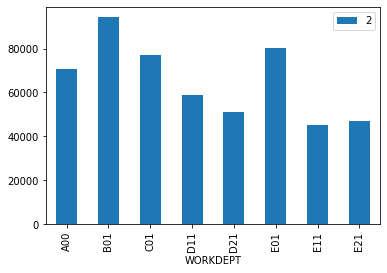

In [8]:
%sql -bar SELECT WORKDEPT, AVG(SALARY) FROM EMPLOYEE GROUP BY WORKDEPT

### Monitoring Activities
You can get an overview of the activities within the cluster by using the Minikube dashboard.

In [19]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=47 onmousedown="window.clipline(47)" onmouseup="window.reset(47)">
minikube dashboard
</pre>
</div>

### Simulating a Db2 Crash
You can simulate a crash in Kubernetes by deleting the Db2 pod. When you kill the pod, Kubernetes will restart the pod automatically for you. The first command will delete the Db2 pod, while the next command will watch the systems as the pod is dropped and recreated. To watch this process work, issue the first command in one command window and the second in another. 

In [20]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=47.1 onmousedown="window.clipline(47.1)" onmouseup="window.reset(47.1)">
kubectl delete pods db2u-db2u-0
</pre>
</div>

Run the following command in the second window to watch the recovery occur.

In [21]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=47.2 onmousedown="window.clipline(47.2)" onmouseup="window.reset(47.2)">
kubectl get pods -w
</pre>
</div>

Keep this status window so you can watch the delete step in the next section.

### Delete Db2 Pods
We can delete the Db2 pods by using Helm. This will properly remove Db2 since you can see that just deleting the pod will not work!

In [22]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=47.5 onmousedown="window.clipline(47.5)" onmouseup="window.reset(47.5)">
helm delete db2u --purge
</pre>
</div>

Check on the status of the purge.

In [23]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=50 onmousedown="window.clipline(50)" onmouseup="window.reset(50)">
kubectl get pods
</pre>
</div>

### SSH into Minikube and Check Docker Status
Now that Db2 has been stopped and purged, we can look into the Docker environment that Minikube is running. The `ssh` command is used to shell into the Minikube environment.

In [24]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=60 onmousedown="window.clipline(60)" onmouseup="window.reset(60)">
minikube ssh 
</pre>
</div>

We can now use Docker commands to list the containers in the system.

In [25]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=61 onmousedown="window.clipline(61)" onmouseup="window.reset(61)">
docker container list
</pre>
</div>

Llist all of the images in the system. Db2 should still be there. The Helm purge command removes the pods, but not any of the Docker images or persistent volumes.

In [26]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=62 onmousedown="window.clipline(62)" onmouseup="window.reset(62)">
docker image list -a
</pre>
</div>

Remember to exit out of Minikube when done. 

In [27]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=62.1 onmousedown="window.clipline(62.1)" onmouseup="window.reset(62.1)">
exit
</pre>
</div>

### Restart Db2 Install (It's much faster!)
Since we still have the Db2 images in the local Docker repository, and the persistent volume is still available, the recreation of Db2 pods is extremely quick.

In [28]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=80 onmousedown="window.clipline(80)" onmouseup="window.reset(80)">
cd ~/notebooks/extras/deployment
./db2u-install --db-type db2oltp \
               --namespace default \
               --release-name db2u \
               --existing-pvc db2claim \
               --cpu-size 2 \
               --memory-size 3Gi
</pre>
</div>

Check its progress to see how long this deployment takes.

In [29]:
%%html
<div style="margin-left: 35px; border-style: solid; border-width: 1px; background-color:#F2F2F2; padding: 10px;" >
<pre id=47.7 onmousedown="window.clipline(47.7)" onmouseup="window.reset(47.7)">
kubectl get pods -w
</pre>
</div>

#### Credits: IBM 2020, Phil Downey [phil.downey1@ibm.com], George Baklarz [baklarz@ca.ibm.com]